# SETTINGS

This notebooks imports the processed data `df.csv` and `df_test.csv` generated in `notebook_02_add_feats.ipynb`. 

The notebook implements cross-validation and builds LightGBM-based regression models to predict item demand in the following steps:
- importing custom profit-driven loss functions from `functions.csv`
- specifying model meta-parameters
- running cross-validation in time on labeled data
- evaluating model profit on OOF predictions
- exporting test predictions as `sub_lgb_[name]_df_[name].csv`

A detailed walkthrough of the code covering the key steps is provided in [this blog post](https://kozodoi.me/python/time%20series/demand%20forecasting/competitions/2020/07/27/demand-forecasting.html).

In [1]:
########## LIBRARIES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import os
import time
import datetime
import random
import multiprocessing
import pickle
import warnings
import gc
from tqdm import tqdm
import importlib

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


In [2]:
########## SETTINGS

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')
%matplotlib inline
gc.enable()

# DATA IMPORT

In [3]:
# read data
df_train = pd.read_csv('../data/prepared/df_v14.csv',      compression = 'gzip')
df_test  = pd.read_csv('../data/prepared/df_test_v14.csv', compression = 'gzip')
print(df_train.shape)
print(df_test.shape)
df_train.head()

(1381116, 476)
(10463, 476)


,day_of_year,days_since_last_order,itemID,mean_price_last_1,mean_price_last_35,mean_price_test,order__abs_energy,order__absolute_sum_of_changes,"order__agg_autocorrelation__f_agg_""mean""__maxlag_40","order__agg_autocorrelation__f_agg_""median""__maxlag_40","order__agg_autocorrelation__f_agg_""var""__maxlag_40","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""var""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""",order__approximate_entropy__m_2__r_0.1,order__approximate_entropy__m_2__r_0.3,order__approximate_entropy__m_2__r_0.5,order__approximate_entropy__m_2__r_0.7,order__approximate_entropy__m_2__r_0.9,order__ar_coefficient__coeff_0__k_10,order__ar_coefficient__coeff_10__k_10,order__ar_coefficient__coeff_1__k_10,order__ar_coefficient__coeff_2__k_10,order__ar_coefficient__coeff_3__k_10,order__ar_coefficient__coeff_4__k_10,order__ar_coefficient__coeff_5__k_10,order__ar_coefficient__coeff_6__k_10,order__ar_coefficient__coeff_7__k_10,order__ar_coefficient__coeff_8__k_10,order__ar_coefficient__coeff_9__k_10,"order__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",order__binned_entropy__max_bins_10,order__c3__lag_1,order__c3__lag_2,order__c3__lag_3,"order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.2","order__change_quantiles__f_agg_""mean""__isabs_Fa

In [4]:
df_test.head()

,day_of_year,days_since_last_order,itemID,mean_price_last_1,mean_price_last_35,mean_price_test,order__abs_energy,order__absolute_sum_of_changes,"order__agg_autocorrelation__f_agg_""mean""__maxlag_40","order__agg_autocorrelation__f_agg_""median""__maxlag_40","order__agg_autocorrelation__f_agg_""var""__maxlag_40","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""var""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","order__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","order__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""",order__approximate_entropy__m_2__r_0.1,order__approximate_entropy__m_2__r_0.3,order__approximate_entropy__m_2__r_0.5,order__approximate_entropy__m_2__r_0.7,order__approximate_entropy__m_2__r_0.9,order__ar_coefficient__coeff_0__k_10,order__ar_coefficient__coeff_10__k_10,order__ar_coefficient__coeff_1__k_10,order__ar_coefficient__coeff_2__k_10,order__ar_coefficient__coeff_3__k_10,order__ar_coefficient__coeff_4__k_10,order__ar_coefficient__coeff_5__k_10,order__ar_coefficient__coeff_6__k_10,order__ar_coefficient__coeff_7__k_10,order__ar_coefficient__coeff_8__k_10,order__ar_coefficient__coeff_9__k_10,"order__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",order__binned_entropy__max_bins_10,order__c3__lag_1,order__c3__lag_2,order__c3__lag_3,"order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0","order__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.2","order__change_quantiles__f_agg_""mean""__isabs_Fa

In [5]:
###### CORRECT COLNAMES

# drop foreign symbols
import re
df_train = df_train.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
df_test  = df_test.rename(columns  = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# ensure that all colnames are unique
def uniquify(df_columns):
    seen = set()
    for item in df_columns:
        fudge = 1
        newitem = item
        while newitem in seen:
            fudge += 1
            newitem = "{}_{}".format(item, fudge)
        yield newitem
        seen.add(newitem)

df_train.columns = uniquify(df_train)
df_test.columns  = uniquify(df_test)

In [6]:
# extract target
y = df_train['target']
X = df_train.drop('target', axis = 1)
del df_train
print(X.shape, y.shape)

# format test data
X_test = df_test.drop('target', axis = 1)
del df_test
print(X_test.shape)

(1381116, 475) (1381116,)
(10463, 475)


In [7]:
# read items
items = pd.read_csv('../data/prepared/items_v1.csv', compression = 'gzip')
print(items.shape)

# keep existing IDs
items = items[items['itemID'].isin(X['itemID'].unique())]
print(items.shape)

(10463, 12)
(10463, 12)


# MODELING

In [29]:
##### IMPORT EVALUATION FUNCTIUONS

# profit function
import functions
importlib.reload(functions)
from functions import asymmetric_mse, asymmetric_mse_eval, profit, postprocess_preds

![](https://kozodoi.me/images/copied_from_nb/images/fig_profit.png)

![](https://kozodoi.me/images/copied_from_nb/images/fig_loss.png)

In [9]:
##### LIST RELEVANT FEATURES

drop_feats = ['itemID', 'day_of_year'] #+ ['category1', 'category2', 'category3'] + list(X.filter(like = '_all_').columns)
features = [var for var in X.columns if var not in drop_feats]
print(len(features), 'features')

473 features


In [10]:
########## MODELING PARAMETERS

### DATA PARTITIONING

# paritioning
num_folds = 7   # no. CV folds
test_days = 14  # no. days in the test set

# settings
seed  = 23


### TRAINING OPTIONS

# target transformation
target_transform = True

# train on positive sales only
train_on_positive = False

# two-stage model
two_stage = True

# use tuned meta-params
tuned_params = True


### CLASSIFIER PARAMETERS

# rounds and options
cores       = 4
stop_rounds = 100
verbose     = 500

# LGB parameters
lgb_params = {
    'boosting_type':    'goss',
    'objective':        asymmetric_mse,
    'metrics':          asymmetric_mse_eval,
    'n_estimators':     1000,
    'learning_rate':    0.1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'lambda_l1':        0.1,
    'lambda_l2':        0.1,
    'silent':           True,
    'verbosity':        -1,
    'nthread' :         cores,
    'random_state':     seed,
}

# load optimal parameters
if tuned_params:
    par_file   = open('../lgb_meta_params_100.pkl', 'rb')
    lgb_params = pickle.load(par_file)
    lgb_params['nthread']      = cores
    lgb_params['random_state'] = seed

# second-stage LGB
if two_stage:
    lgb_classifier_params              = lgb_params.copy()
    lgb_classifier_params['objective'] = 'binary'
    lgb_classifier_params['metrics']   = 'logloss'

![](https://kozodoi.me/images/copied_from_nb/images/fig_partitioning.png)

In [16]:
##### CROSS-VALIDATION LOOP

# placeholders
importances   = pd.DataFrame()
preds_oof     = np.zeros((num_folds, items.shape[0]))
reals_oof     = np.zeros((num_folds, items.shape[0]))
prices_oof    = np.zeros((num_folds, items.shape[0]))
preds_test    = np.zeros(items.shape[0])
oof_rmse      = []
oof_profit    = []
oracle_profit = []
clfs          = []
train_idx     = []
valid_idx     = []

# objects
train_days = X['day_of_year'].max() - test_days + 1 - num_folds - X['day_of_year'].min() # no. days in the train set
time_start = time.time()

# modeling loop
for fold in range(num_folds):
    
    ##### PARTITIONING
    
    # validation dates
    if fold == 0:
        v_end = X['day_of_year'].max()
    else:
        v_end = v_end - 1
    v_start = v_end
    
    # training dates
    t_end   = v_start - (test_days + 1)
    t_start = t_end   - (train_days - 1)
    
    # extract index
    train_idx.append(list(X[(X.day_of_year >= t_start) & (X.day_of_year <= t_end)].index))
    valid_idx.append(list(X[(X.day_of_year >= v_start) & (X.day_of_year <= v_end)].index))   
    
    # extract samples
    X_train, y_train = X.iloc[train_idx[fold]][features], y.iloc[train_idx[fold]]
    X_valid, y_valid = X.iloc[valid_idx[fold]][features], y.iloc[valid_idx[fold]]
    X_test = X_test[features]
    
    # keep positive cases
    if train_on_positive:
        y_train = y_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]
        X_train = X_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]

    # information
    print('-' * 65)
    print('- train period days: {} -- {} (n = {})'.format(t_start, t_end, len(train_idx[fold])))
    print('- valid period days: {} -- {} (n = {})'.format(v_start, v_end, len(valid_idx[fold])))
    print('-' * 65)

    
    ##### MODELING
    
    # target transformation
    if target_transform:
        y_train = np.sqrt(y_train)
        y_valid = np.sqrt(y_valid)
        
    # first stage model
    if two_stage:
        y_train_binary, y_valid_binary = y_train.copy(), y_valid.copy()
        y_train_binary[y_train_binary > 0] = 1
        y_valid_binary[y_valid_binary > 0] = 1
        clf_classifier = lgb.LGBMClassifier(**lgb_classifier_params) 
        clf_classifier = clf_classifier.fit(X_train, y_train_binary, 
                                            eval_set              = [(X_train, y_train_binary), (X_valid, y_valid_binary)],
                                            eval_metric           = 'logloss',
                                            early_stopping_rounds = stop_rounds,
                                            verbose               = verbose)
        preds_oof_fold_binary  = clf_classifier.predict(X_valid)
        preds_test_fold_binary = clf_classifier.predict(X_test)

    # training
    clf = lgb.LGBMRegressor(**lgb_params) 
    clf = clf.fit(X_train, y_train, 
                  eval_set              = [(X_train, y_train), (X_valid, y_valid)], 
                  eval_metric           = asymmetric_mse_eval,
                  sample_weight         = X_train['simulationPrice'].values,
                  eval_sample_weight    = [X_train['simulationPrice'].values, X_valid['simulationPrice'].values],
                  early_stopping_rounds = stop_rounds,
                  verbose               = verbose)
    clfs.append(clf)
    
    # inference
    if target_transform:      
        preds_oof_fold  = postprocess_preds(clf.predict(X_valid)**2)
        reals_oof_fold  = y_valid**2
        preds_test_fold = postprocess_preds(clf.predict(X_test)**2) / num_folds
    else:
        preds_oof_fold  = postprocess_preds(clf.predict(X_valid))
        reals_oof_fold  = y_valid
        preds_test_fold = postprocess_preds(clf.predict(X_test)) / num_folds
        
    # impute zeros
    if train_on_positive:
        preds_oof_fold[(X_valid['order_sum_last_28'] == 0) & (X_valid['promo_in_test'] == 0)] = 0
        preds_test_fold[(X_test['order_sum_last_28'] == 0) & (X_test['promo_in_test']  == 0)] = 0
        
    # multiply with first stage predictions
    if two_stage:
        preds_oof_fold  = preds_oof_fold  * np.round(preds_oof_fold_binary)
        preds_test_fold = preds_test_fold * np.round(preds_test_fold_binary)

    # write predictions
    preds_oof[fold, :] = preds_oof_fold
    reals_oof[fold, :] = reals_oof_fold
    preds_test        += preds_test_fold
    
    # save prices
    prices_oof[fold, :] = X.iloc[valid_idx[fold]]['simulationPrice'].values
        
        
    ##### EVALUATION

    # evaluation
    oof_rmse.append(np.sqrt(mean_squared_error(reals_oof[fold, :], 
                                               preds_oof[fold, :])))
    oof_profit.append(profit(reals_oof[fold, :], 
                             preds_oof[fold, :], 
                             price = X.iloc[valid_idx[fold]]['simulationPrice'].values))
    oracle_profit.append(profit(reals_oof[fold, :], 
                                reals_oof[fold, :], 
                                price = X.iloc[valid_idx[fold]]['simulationPrice'].values))
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold'] = fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)
    
    # information
    print('-' * 65)
    print('FOLD {:d}/{:d}: RMSE = {:.2f}, PROFIT = {:.0f}'.format(fold + 1, 
                                                                  num_folds, 
                                                                  oof_rmse[fold], 
                                                                  oof_profit[fold]))
    print('-' * 65)
    print('')
    

# print performance
print('')
print('-' * 65)
print('- AVERAGE RMSE:   {:.2f}'.format(np.mean(oof_rmse)))
print('- AVERAGE PROFIT: {:.0f} ({:.2f}%)'.format(np.mean(oof_profit), 100 * np.mean(oof_profit) / np.mean(oracle_profit)))
print('- RUNNING TIME:   {:.2f} minutes'.format((time.time() - time_start) / 60))
print('-' * 65)

-----------------------------------------------------------------
- train period days: 41 -- 151 (n = 1161393)
- valid period days: 166 -- 166 (n = 10463)
-----------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[500]	training's binary_logloss: 0.24001	valid_1's binary_logloss: 0.347445
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.238417	valid_1's binary_logloss: 0.347182
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.660717	training's asymmetric_mse_eval: 3.19176	valid_1's rmse: 0.983343	valid_1's asymmetric_mse_eval: 5.90943
Early stopping, best iteration is:
[788]	training's rmse: 0.611924	training's asymmetric_mse_eval: 2.82734	valid_1's rmse: 0.98004	valid_1's asymmetric_mse_eval: 5.83945
-----------------------------------------------------------------
FOLD 1/7: RMSE = 74.46, PROFIT = 4146664
------------------------------------------------------

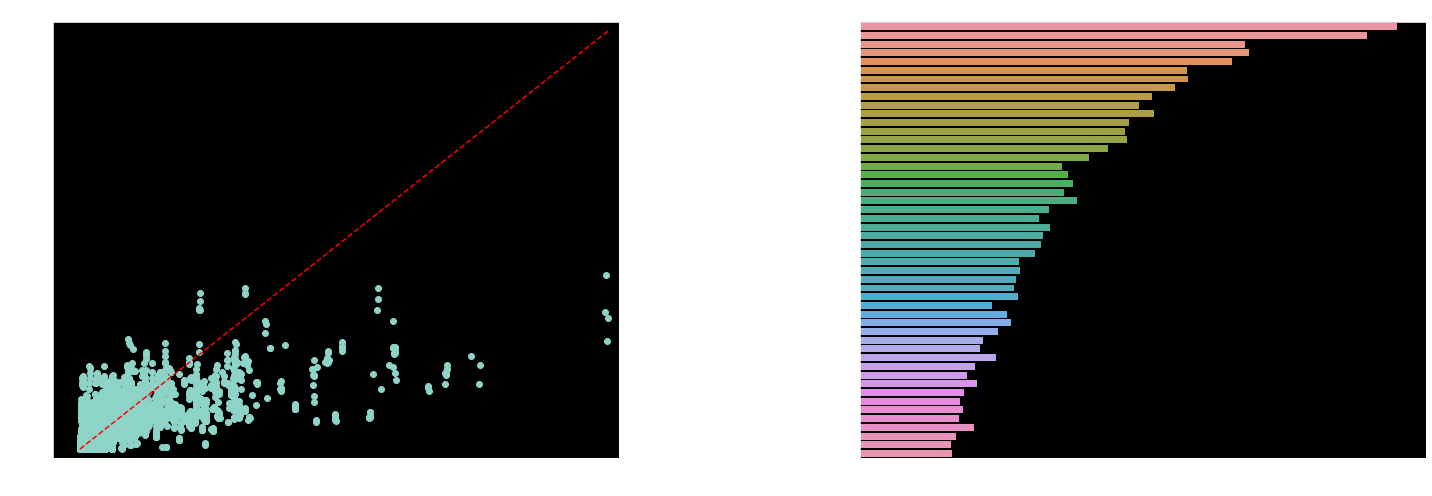

In [18]:
##### EVALUATION

fig = plt.figure(figsize = (20, 7))

# residual plot
plt.subplot(1, 2, 1)
plt.scatter(reals_oof.reshape(-1), preds_oof.reshape(-1))
axis_lim = np.max([reals_oof.max(), preds_oof.max()])
plt.ylim(top   = 1.02*axis_lim)
plt.xlim(right = 1.02*axis_lim)
plt.plot((0, axis_lim), (0, axis_lim), 'r--')
plt.title('Residual Plot')
plt.ylabel('Predicted demand')
plt.xlabel('Actual demand')

# feature importance
plt.subplot(1, 2, 2)
top_feats = 50
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()

# export
plt.savefig('../lgb_performance.pdf')

# SUBMISSION

In [14]:
##### SUBMISSION

# model name
name = 'lgb_v27_df_v14'
sub_name = name + '_profit_' + str(int(np.round(np.mean(oof_profit))))

# save OOF preds
oof = np.stack((preds_oof, reals_oof, prices_oof))
np.save('../oof_preds/' + sub_name + '.npy', oof)
print(oof.shape)

# save submissiion
sub = pd.read_csv('../submissions/sample_submission.csv', sep = '|')
sub['demandPrediction'] = postprocess_preds(preds_test)
sub.to_csv('../submissions/sub_' + sub_name + '.csv', sep = '|', index = False)
print(sub.shape)
sub.head()

(3, 7, 10463)
(10463, 2)


,itemID,demandPrediction
0,1,5
1,2,14
2,3,2
3,4,6
4,5,12
